# MNIST Digit Classifier Demo

This notebook demonstrates how to train and use the MNIST digit classifier model.

In [36]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('.'))))

from model import MNISTClassifier
from train import train_model
from inference import MNISTPredictor

# Set random seed for reproducibility
torch.manual_seed(42)

In [37]:
# Define transformations for the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Load MNIST training dataset
train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Load MNIST test dataset
test_dataset = datasets.MNIST('../data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000)

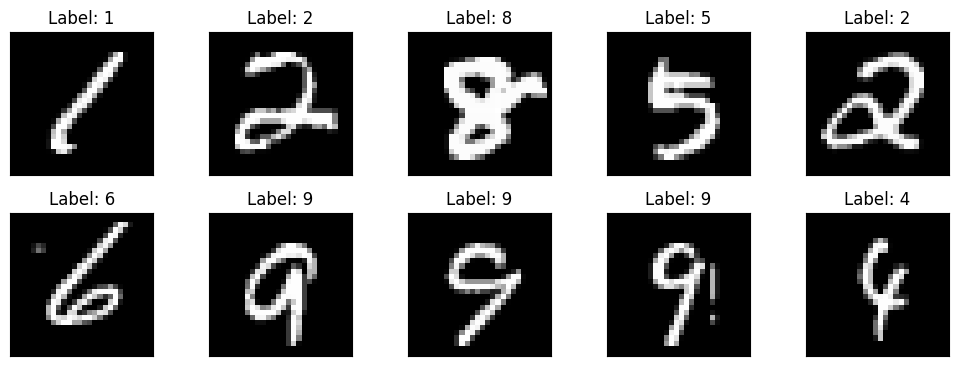

In [38]:
# Visualise Some Training Examples
# Get a batch of training data
examples = iter(train_loader)
example_data, example_targets = next(examples)

# Create a figure to display the images
fig = plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title(f"Label: {example_targets[i]}")
    plt.xticks([])
    plt.yticks([])
plt.show()

In [39]:
# Train the Model
# Create model
model = MNISTClassifier()

# Train model
print("Starting model training...")
trained_model, history = train_model(model, train_loader, test_loader, epochs=2)

print("Training completed successfully!")

Starting model training...
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298333
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.926406
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.564259
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.435498
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.414136
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.314821
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.240722
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.202618
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.237738
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.202438
Epoch 1: Train Loss: 0.5491, Test Loss: 0.1246, Test Accuracy: 96.25%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.357425
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.181549
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.123645
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.155305
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.137628
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.201280
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.222797
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.202181
Train Epoch: 2 

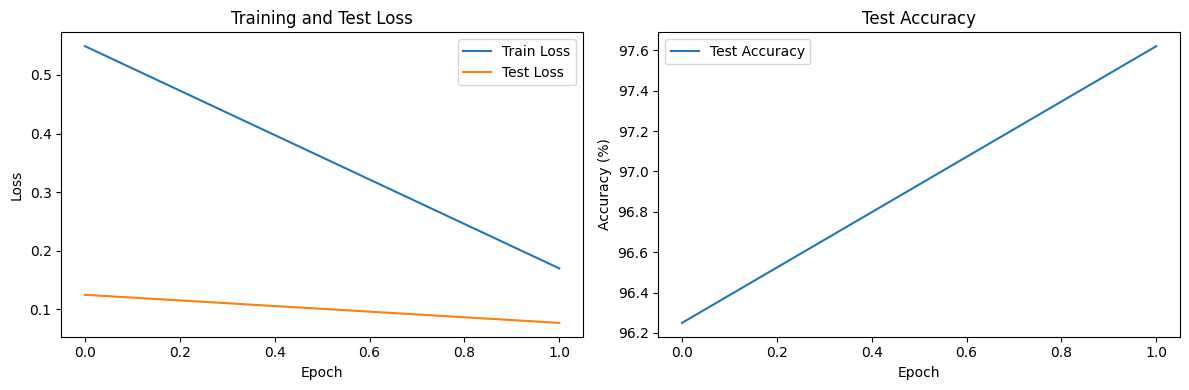

In [40]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training and test loss
plt.subplot(1, 2, 1)
plt.plot(history['train_losses'], label='Train Loss')
plt.plot(history['test_losses'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(history['test_accuracies'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Test Accuracy')

plt.tight_layout()
plt.show()

In [41]:
# Create directory if it doesn't exist
os.makedirs('../saved_models', exist_ok=True)

# Save the model
torch.save(trained_model.state_dict(), '../saved_models/mnist_classifier.pth')
print("Model saved to '../saved_models/mnist_classifier.pth'")

Model saved to '../saved_models/mnist_classifier.pth'


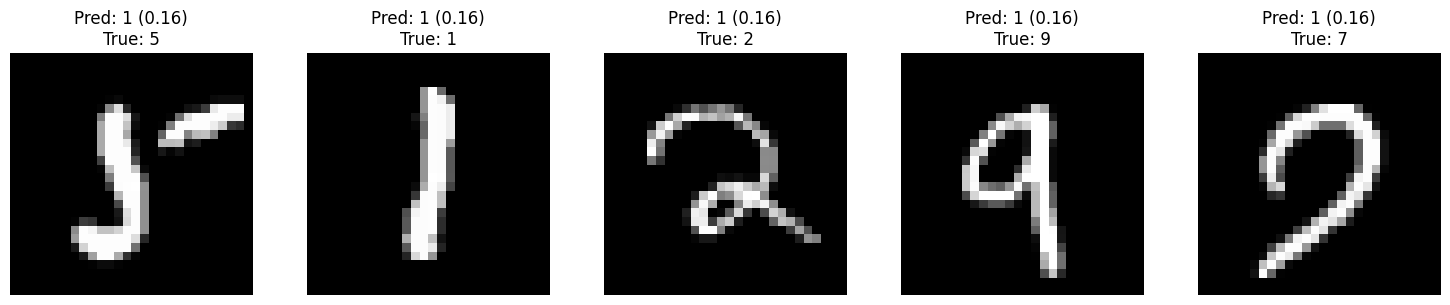

In [42]:
# Test the Model on New Images
# Create a predictor with the trained model
predictor = MNISTPredictor('../saved_models/mnist_classifier.pth')

# Get some test images
test_examples = iter(test_loader)
test_images, test_labels = next(test_examples)

# Select 5 random test images
indices = np.random.choice(len(test_images), 5, replace=False)
test_samples = [test_images[i] for i in indices]
test_sample_labels = [test_labels[i].item() for i in indices]

# Make predictions
predictions = [predictor.predict(sample.squeeze().numpy()) for sample in test_samples]

# Display the images and predictions
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    # Display image
    axes[i].imshow(test_samples[i].squeeze().numpy(), cmap='gray')
    
    # Set title with prediction and ground truth
    pred_digit = predictions[i]['predicted_digit']
    confidence = predictions[i]['confidence']
    true_label = test_sample_labels[i]
    axes[i].set_title(f"Pred: {pred_digit} ({confidence:.2f})\nTrue: {true_label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

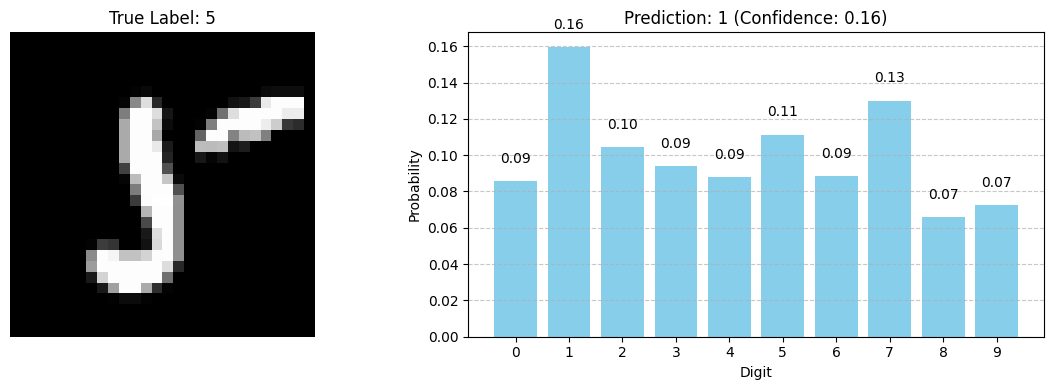

In [43]:
# Select one of the predictions
selected_idx = 0
selected_prediction = predictions[selected_idx]
selected_image = test_samples[selected_idx]
selected_label = test_sample_labels[selected_idx]

# Create a figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Display the image
ax1.imshow(selected_image.squeeze().numpy(), cmap='gray')
ax1.set_title(f"True Label: {selected_label}")
ax1.axis('off')

# Plot the probabilities as a bar chart
digits = list(range(10))
ax2.bar(digits, selected_prediction['probabilities'], color='skyblue')

# Add labels and title
ax2.set_xlabel('Digit')
ax2.set_ylabel('Probability')
ax2.set_title(f"Prediction: {selected_prediction['predicted_digit']} (Confidence: {selected_prediction['confidence']:.2f})")

# Set x-axis ticks
ax2.set_xticks(digits)

# Add grid
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Add probability values above each bar
for i, prob in enumerate(selected_prediction['probabilities']):
    ax2.text(i, prob + 0.01, f'{prob:.2f}', ha='center')

plt.tight_layout()
plt.show()

## Conclusion

In this notebook, I have managed to:

1. Load and prepare the MNIST dataset
2. Train a CNN model for digit classification
3. Evaluate the model's performance
4. Make predictions on new images
5. Visualize the prediction probabilities

The model achieves high accuracy on the MNIST dataset, demonstrating the effectiveness of CNNs for image classification tasks.
"""